In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
import xgboost as xgb

2024-07-30 11:13:23.073675: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 11:13:23.266535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 11:13:26.061858: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Reading NASA dataset from exact NEOEN site 
# Read the CSV data into a Pandas DataFrame
from io import StringIO
df_met_nasa = pd.read_csv('/mnt/data-r6/ahilan/dataset/neoen/process/NASA-weather-data-sattelite_20200101_20240131_034d76S_145d93E_LST.csv',skiprows=16)
df_met_nasa = df_met_nasa.rename(columns={'MO': 'MONTH','DY': 'DAY', 'HR': 'HOUR' , 'ALLSKY_SFC_SW_DWN' : 'GHI',  'ALLSKY_SFC_SW_DNI': 'DNI', 'ALLSKY_SFC_SW_DIFF' : 'DHI', 'T2M': 'Temp', 'WS10M': 'Wind', 'QV2M': 'HUMDY', 'ALLSKY_SRF_ALB' : 'ALBEDO', 'PRECTOTCORR': 'PRECIP'})
df_met_nasa['datetime'] = pd.to_datetime(df_met_nasa[['YEAR', 'MONTH', 'DAY', 'HOUR']])
df_met_nasa.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR'], inplace=True)
df_met_nasa.set_index('datetime', inplace=True)
print(df_met_nasa.columns)

Index(['GHI', 'DNI', 'DHI', 'ALBEDO', 'Temp', 'HUMDY', 'PRECIP', 'Wind'], dtype='object')


Australia/Sydney


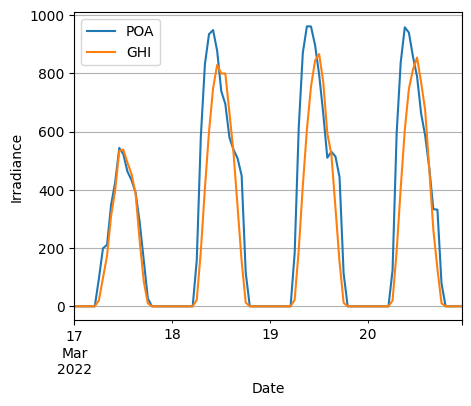

In [3]:
from pvlib import location
from pvlib import irradiance
from timezonefinder import TimezoneFinder
from pytz import timezone
from mpl_toolkits.mplot3d import Axes3D
import pvlib

start_date = df_met_nasa.index.min()
end_date = df_met_nasa.index.max()

lat, lon = -34.76, 145.93

# Find the timezone name using TimezoneFinder
tf = TimezoneFinder()
tz_name = tf.timezone_at(lat=lat, lng=lon)

# Use pytz to get the timezone object
tz = timezone(tz_name)
print(tz)
# Create location object to store lat, lon, timezone
site_location = location.Location(lat, lon, tz=tz)

times = pd.date_range(start=start_date, end=end_date, freq='H')
#times = pd.date_range(start='2020-01-01', end='2020-01-03', freq='H')

solar_position = site_location.get_solarposition(times=times)


# Extract zenith and azimuth angles
zenith_angles = solar_position['zenith']
azimuth_angles = solar_position['azimuth']


ghi = df_met_nasa['GHI']
dni = df_met_nasa['DNI']
dhi = df_met_nasa['DHI']
azimuth_angle = 0  # azimuth angle (north-facing)
tilt = solar_position['elevation'].clip(lower=0) # for single axis tracker north-south


def calculate_dynamic_aoi(tilt, azimuth_angle, solar_azimuth, solar_zenith):
    # Convert angles from degrees to radians
    azimuth_angle_rad = np.radians(azimuth_angle)
    solar_azimuth_rad = np.radians(solar_azimuth)
    solar_zenith_rad = np.radians(solar_zenith)
    
    # For single-axis tracker, tilt is approximately the solar zenith angle
    tilt_rad = np.radians(tilt)
    
    # Calculate AOI
    aoi = np.degrees(np.arccos(
        np.cos(solar_zenith_rad) * np.cos(tilt_rad) +
        np.sin(solar_zenith_rad) * np.sin(tilt_rad) * np.cos(solar_azimuth_rad - azimuth_angle_rad)
 ))
    
    return aoi

aoi = calculate_dynamic_aoi(tilt, azimuth_angle, solar_position['azimuth'], 90-solar_position['zenith'])


def calculate_poa_irradiance(dni, dhi, ghi, aoi, tilt, albedo=0.2):
    """
    Calculate the plane of array (POA) irradiance.
    
    Parameters:
    dni (float): Direct Normal Irradiance (W/m^2)
    dhi (float): Diffuse Horizontal Irradiance (W/m^2)
    ghi (float): Global Horizontal Irradiance (W/m^2)
    aoi (float): Angle of Incidence (degrees)
    tilt (float): Tilt angle of the panel (degrees)
    albedo (float): Ground reflectance (default is 0.2)
    
    Returns:
    float: Total POA irradiance (W/m^2)
    """
    
    # Convert angles from degrees to radians
    aoi_rad = np.radians(aoi)
    tilt_rad = np.radians(tilt)
    
    # Direct component
    poa_direct = dni * np.cos(aoi_rad)

    # Diffuse component (using the isotropic sky model)
    poa_diffuse = dhi * (1 + np.cos(tilt_rad)) / 2

    # Ground-reflected component
    poa_ground_reflected = ghi * albedo * (1 - np.cos(tilt_rad)) / 2

    # Total POA irradiance
    poa_total = poa_direct + poa_diffuse + poa_ground_reflected
    
    return poa_total


df_met_nasa['POA'] = calculate_poa_irradiance(dni, dhi, ghi, aoi, tilt, albedo=df_met_nasa['ALBEDO'])

start_date = '2022-03-17'
end_date = '2022-03-20'

'''
# Plotting
plt.figure(figsize=(12, 6))
# Plot zenith angle
plt.subplot(3, 1, 1)
plt.plot(zenith_angles.index, zenith_angles, label='Zenith Angle')
plt.xlabel('Time')
plt.ylabel('Zenith Angle (degrees)')
plt.title('Solar Zenith Angle over Time')
plt.legend()
plt.grid(True)

# Plot azimuth angle
plt.subplot(3, 1, 2)
plt.plot(azimuth_angles.index, azimuth_angles, label='Azimuth Angle', color='orange')
plt.xlabel('Time')
plt.ylabel('Azimuth Angle (degrees)')
plt.title('Solar Azimuth Angle over Time')
plt.legend()
plt.grid(True)

# Plot tilt angle
plt.subplot(3, 1, 3)
plt.plot(tilt.index, tilt, label='Tilt Angle', color='red')
plt.xlabel('Time')
plt.ylabel('Tilt Angle (degrees)')
plt.title('Tilt Angle over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
'''

df_met_nasa['POA'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='POA')
df_met_nasa['GHI'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4), label='GHI')
plt.legend()
plt.ylabel('Irradiance')
plt.xlabel('Date')
plt.grid(True)
plt.show()


Index(['Temp_mes', 'POA_mes', 'Wind_mes'], dtype='object')


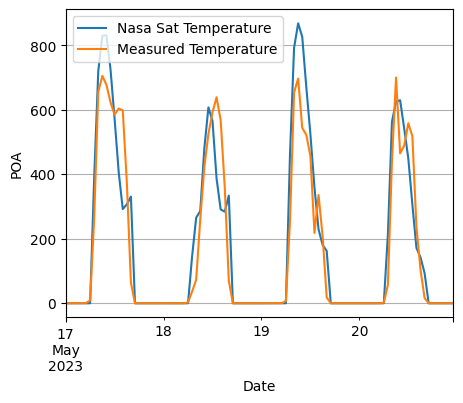

"\ndf_pow_32A = df_pow_32A.rename(columns={'Timestamp': 'time','32-A': 'Power' })\ndf_pow_32A.set_index('time', inplace=True)\ndf = df_pow_32A.resample('1min').mean()\n\nprint(df.shape)\n"

In [4]:
#df_pow = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/full_inv_pow_1min.pkl')
#df_pow_32A = df_pow[['Timestamp','32-A']]
#df_pow_32A = df_pow_32A.rename(columns={'Timestamp': 'time','32-A': 'Power' })
#df_pow_32A.set_index('time', inplace=True)
#print(df_pow_32A.columns)


df_met_measured = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/met_5min.pkl')
df_met_measured = df_met_measured.rename(columns={'Timestamp': 'time'})
df_met_measured.set_index('time', inplace=True)

df_met_measured = df_met_measured.shift(periods=-90, freq='T')

df_met_measured = df_met_measured[['Temp','POA','Wind']].resample('H').mean()
df_met_measured = df_met_measured.rename(columns={'Temp': 'Temp_mes','POA': 'POA_mes', 'Wind': 'Wind_mes'})
print(df_met_measured.columns)



#df_met_sat = pd.read_parquet('/mnt/data-r6/ahilan/dataset/neoen/process/neoen-weather-data-sattelite.parquet', engine='pyarrow')
#df_met_sat.index = df_met_sat.index.tz_localize(None)
#df_met_sat = df_met_sat[['temp', 'poa_global', 'wind']]
#df_met_sat = df_met_sat.rename(columns={'temp': 'Temp_sat','poa_global': 'POA_sat', 'wind': 'Wind_sat'})
#print(df_met_sat.columns)

df_met_nasa_temp = df_met_nasa[['Temp', 'POA', 'Wind','GHI']]
df_met_nasa_temp = df_met_nasa_temp.rename(columns={'Temp': 'Temp_nasa','POA': 'POA_nasa', 'Wind': 'Wind_nasa', 'GHI' : 'GHI_nasa'})


data = pd.merge(df_met_measured, df_met_nasa_temp, left_index=True, right_index=True)


data = data[data['Temp_mes'] < 40]
data = data[data['Temp_mes'] > 0]


#start_date = data.index.min()
#end_date = data.index.max()



start_date = '2023-05-17'
end_date = '2023-05-20'


data['POA_nasa'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='Nasa Sat Temperature')
data['POA_mes'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='Measured Temperature')
plt.legend()
plt.ylabel('POA')
plt.xlabel('Date')
plt.grid(True)
plt.show()


#data['Temp_nasa'].resample('H').mean().plot(figsize=(5, 4))
#plt.ylabel('Temperature')
#plt.xlabel('Date')
#plt.grid(True)
#plt.show()


'''
X = data[['Temp_sat']]
y = data[['Temp_mes']]


print(df_pow_32A.index.min())
print(df_pow_32A.index.max()
'''


'''
#start_date = '2023-03-17'
#end_date = '2023-03-18'

#start_date = '2023-03-17 00:00:00+11:00'
#end_date = '2023-03-18 00:00:00+11:00'

start_date = df_pow_32A.index.min()
end_date = df_pow_32A.index.max()


print(start_date)
print(end_date)
'''

    
'''
print(df_met_sat['temp'][start_date:end_date])


print(df_met_measured['Temp'][start_date:end_date].resample('H').mean())


#print(df_met_sat['temp'][start_date:end_date].resample('5T').mean())
#print(df_met_measured['Temp'][start_date:end_date])

#df_met_sat['temp'].resample('5min').mean().plot(figsize=(5, 4))
#plt.ylabel('Measured Temperature')
#plt.xlabel('Date')
#plt.grid(True)
#plt.show()
'''

'''
df_pow_32A = df_pow_32A.rename(columns={'Timestamp': 'time','32-A': 'Power' })
df_pow_32A.set_index('time', inplace=True)
df = df_pow_32A.resample('1min').mean()

print(df.shape)
'''

Train MSE: 0.7806040386301085
Test MSE: 0.7322996737481459
Train R2: 0.48502650402069336
Test R2: 0.47601858167943734


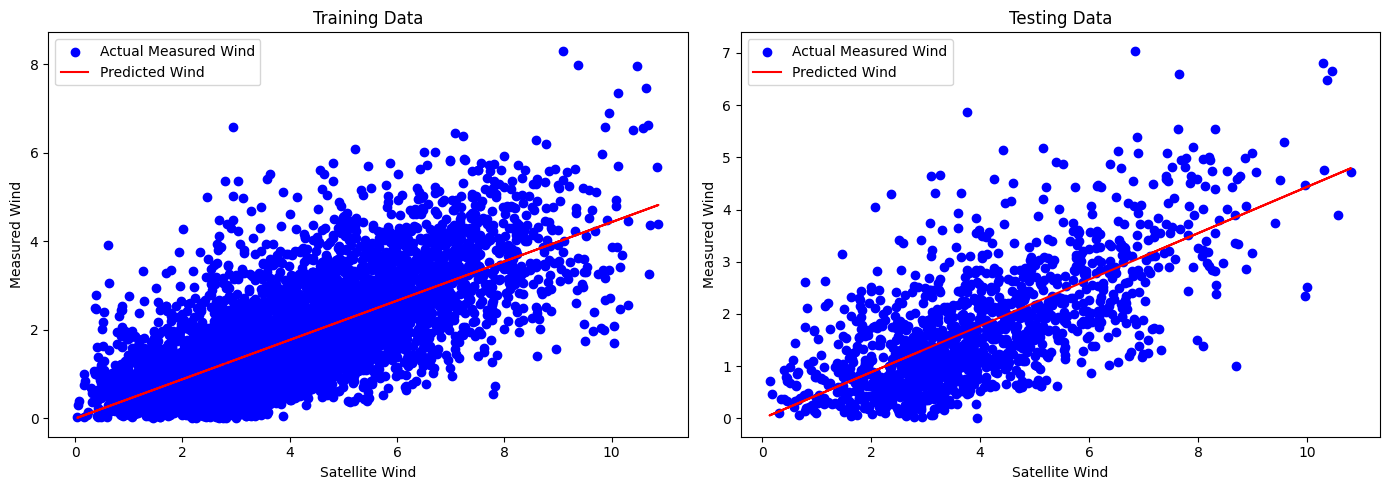

(6751,)


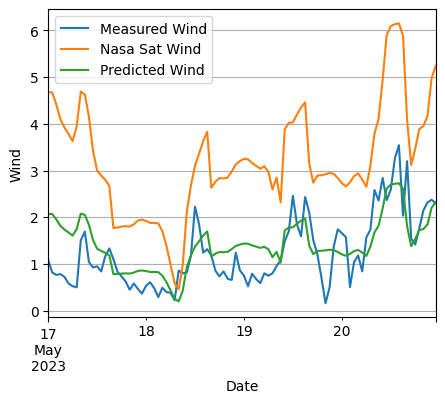

In [5]:
# Simple Linear regression modelling to predict actual temperature from satellite data temperature
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

data = data[['Wind_mes','Wind_nasa']]

data = data[data['Wind_mes']<12]
data = data[data['Wind_nasa']<12]
# Filtering constant values
# Define the window size
window_size = 2

# Check if the values in the rolling window are the same

data['constant'] = data['Wind_mes'].rolling(window=window_size).apply(lambda x: np.all(x == x[0]), raw=True)

# Fill NaN values with 0 (occurs for the first 'window_size - 1' elements)
data['constant'].fillna(0, inplace=True)
data['constant'] = data['constant'].astype(bool)

# Filter out constant value rows
data_filtered = data[~data['constant']].drop(columns=['constant'])

data = data_filtered



# Split the data into features (X) and target (y)
X = data[['Wind_nasa']].values
y = data['Wind_mes'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

from sklearn.linear_model import LinearRegression

# Define the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

# Plot the results
plt.figure(figsize=(14, 5))

# Training data
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color='blue', label='Actual Measured Wind')
plt.plot(X_train, y_train_pred, color='red', label='Predicted Wind')
plt.title('Training Data')
plt.xlabel('Satellite Wind')
plt.ylabel('Measured Wind')
plt.legend()

# Testing data
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color='blue', label='Actual Measured Wind')
plt.plot(X_test, y_test_pred, color='red', label='Predicted Wind')
plt.title('Testing Data')
plt.xlabel('Satellite Wind')
plt.ylabel('Measured Wind')
plt.legend()

plt.tight_layout()
plt.show()


y_pred = model.predict(X)
print(y_pred.shape)
data['Wind_predict'] = y_pred

#start_date = data.index.min()
#end_date = data.index.max()

start_date = '2023-05-17'
end_date = '2023-05-20'

data['Wind_mes'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='Measured Wind')
data['Wind_nasa'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='Nasa Sat Wind')
data['Wind_predict'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='Predicted Wind')
plt.legend()
plt.ylabel('Wind')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

#data = data[['Wind_mes','Wind_nasa']]

# Features and target variable
# Split the data into features (X) and target (y)
X = data[['Wind_nasa']].values
y = data['Wind_mes'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize XGBoost model
#model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.001, max_depth=25)

# Train the model
#model.fit(X_train, y_train)


xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=1)


# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_



# Make predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

# Plot the results
plt.figure(figsize=(14, 5))

# Training data
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color='blue', label='Actual Measured Wind Speed')
plt.plot(X_train, y_train_pred, color='red', label='Predicted Wind Speed')
plt.title('Training Data')
plt.xlabel('Satellite Wind Speed')
plt.ylabel('Measured Wind Speed')
plt.legend()

# Testing data
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color='blue', label='Actual Measured Wind Speed')
plt.plot(X_test, y_test_pred, color='red', label='Predicted Wind Speed')
plt.title('Testing Data')
plt.xlabel('Satellite Wind Speed')
plt.ylabel('Measured Wind Speed')
plt.legend()

plt.tight_layout()
plt.show()


y_pred = model.predict(X)
print(y_pred.shape)
data['Wind_predict'] = y_pred

#start_date = data.index.min()
#end_date = data.index.max()

start_date = '2023-05-17'
end_date = '2023-05-20'

data['Wind_mes'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='Measured Wind Speed')
data['Wind_nasa'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='Nasa Sat Wind Speed')
data['Wind_predict'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='Predicted Wind Speed')
plt.legend()
plt.ylabel('Wind Speed')
plt.xlabel('Date')
plt.grid(True)
plt.show()


Fitting 3 folds for each of 23328 candidates, totalling 69984 fits


In [23]:
# Simple attention based LSTM modelling to predict actual temperature from satellite data temperature
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Set a seed for reproducibility
tf.random.set_seed(42)

data = data[['Wind_mes','Wind_nasa']]

# Features and target variable
# Split the data into features (X) and target (y)
X = data[['Wind_nasa']].values
y = data['Wind_mes'].values

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Prepare the data for LSTM (convert to sequences)
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24  # You can adjust this based on your data
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


def create_lstm_with_attention(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(64, return_sequences=True)(inputs)
    attention = Attention()([lstm_out, lstm_out])
    concat = Concatenate()([lstm_out, attention])
    lstm_out_2 = LSTM(64)(concat)
    outputs = Dense(1)(lstm_out_2)
    
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])
    return model



input_shape = (X_train.shape[1], X_train.shape[2])
model = create_lstm_with_attention(input_shape)
model.summary()

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs= 100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

'''
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs= 50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)
'''

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 24, 1)]              0         []                            
                                                                                                  
 lstm_5 (LSTM)               (None, 24, 64)               16896     ['input_2[0][0]']             
                                                                                                  
 attention_1 (Attention)     (None, 24, 64)               0         ['lstm_5[0][0]',              
                                                                     'lstm_5[0][0]']              
                                                                                                  
 concatenate_1 (Concatenate  (None, 24, 128)              0         ['lstm_5[0][0]',        

2024-07-24 19:28:15.413407: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2400 num_cores: 40 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 14417920 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


153/154 [============================>.] - ETA: 0s - loss: 7.3345e-04 - mse: 7.3345e-04

2024-07-24 19:28:28.826193: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2400 num_cores: 40 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 14417920 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


154/154 [==============================] - 23s 79ms/step - loss: 7.3318e-04 - mse: 7.3318e-04 - val_loss: 7.1006e-04 - val_mse: 7.1006e-04
Epoch 2/100
154/154 [==============================] - 9s 60ms/step - loss: 7.2093e-04 - mse: 7.2093e-04 - val_loss: 3.2345e-04 - val_mse: 3.2345e-04
Epoch 3/100
154/154 [==============================] - 9s 62ms/step - loss: 7.1208e-04 - mse: 7.1208e-04 - val_loss: 2.9811e-04 - val_mse: 2.9811e-04
Epoch 4/100
154/154 [==============================] - 9s 61ms/step - loss: 7.0826e-04 - mse: 7.0826e-04 - val_loss: 2.9802e-04 - val_mse: 2.9802e-04
Epoch 5/100
154/154 [==============================] - 9s 61ms/step - loss: 7.0119e-04 - mse: 7.0119e-04 - val_loss: 2.9604e-04 - val_mse: 2.9604e-04
Epoch 6/100
154/154 [==============================] - 9s 60ms/step - loss: 7.0082e-04 - mse: 7.0082e-04 - val_loss: 2.9766e-04 - val_mse: 2.9766e-04
Epoch 7/100
154/154 [==============================] - 9s 60ms/step - loss: 7.0076e-04 - mse: 7.0076e-04 - val_

"\nmodel = Sequential([\n    LSTM(64, return_sequences=True, input_shape=(time_steps, 1)),\n    Dropout(0.2),\n    LSTM(64),\n    Dropout(0.2),\n    Dense(1)\n])\n\noptimizer = Adam(learning_rate=1e-4)\nmodel.compile(optimizer=optimizer, loss='mse')\nmodel.summary()\n\n# Define early stopping to prevent overfitting\nearly_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)\n\n# Train the model\nhistory = model.fit(\n    X_train, y_train,\n    epochs= 50,\n    batch_size=32,\n    validation_split=0.2,\n    callbacks=[early_stopping]\n)\n"

192/192 [==============================] - 4s 19ms/step - loss: 5.8312e-04 - mse: 5.8312e-04
Train Loss: 0.0005831229500472546, Test MSE: 0.0005831229500472546
48/48 [==============================] - 1s 19ms/step - loss: 2.7677e-04 - mse: 2.7677e-04
Test Loss: 0.00027676933677867055, Test MSE: 0.00027676933677867055


2024-07-24 19:45:42.288727: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2400 num_cores: 40 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 14417920 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


48/48 [==============================] - 1s 18ms/step
Train MSE: 1.9766482002935728
Test MSE: 0.9381824249481838
Train R2: 0.23015606434944613
Test R2: 0.3406980273582435
240/240 [==============================] - 5s 19ms/step
(7664, 1)


/tmp/ipykernel_1327626/1943918608.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_['Wind_predict'] = y_pred


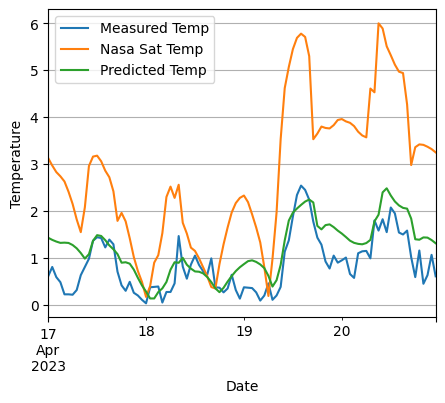

"\n# Plot predictions vs actual values\nimport matplotlib.pyplot as plt\n\nplt.figure(figsize=(14, 5))\nplt.plot(y_test_actual, label='Actual Temperature')\nplt.plot(y_pred, label='Predicted Temperature')\nplt.title('Temperature Prediction')\nplt.xlabel('Time Steps')\nplt.ylabel('Temperature')\nplt.legend()\nplt.show()\n"

In [24]:
# Evaluate the model on the test set
loss, mse = model.evaluate(X_train, y_train)
print(f'Train Loss: {loss}, Test MSE: {mse}')

loss, mse = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MSE: {mse}')


# Make predictions
y_train_pred_scaled = model.predict(X_train)
y_test_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_actual = scaler_y.inverse_transform(y_train)

y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)


# Calculate metrics
train_mse = mean_squared_error(y_train_actual, y_train_pred)
test_mse = mean_squared_error(y_test_actual, y_test_pred)
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')


y_pred_scaled = model.predict(X_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

data_ = data.iloc[24:]

print(y_pred.shape)
data_['Wind_predict'] = y_pred

#start_date = data.index.min()
#end_date = data.index.max()

start_date = '2023-04-17'
end_date = '2023-04-20'

data_['Wind_mes'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='Measured Temp')
data_['Wind_nasa'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='Nasa Sat Temp')
data_['Wind_predict'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='Predicted Temp')
plt.legend()
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.grid(True)
plt.show()

'''
# Plot predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, label='Actual Temperature')
plt.plot(y_pred, label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()
'''

In [18]:
# Simple LSTM modelling to predict actual temperature from satellite data temperature
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


data = data[['Temp_mes','Temp_nasa']]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert to DataFrame
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)


def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length,1]
        target = data[i+seq_length,0]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

seq_length = 24  # Example sequence length
X, y = create_sequences(scaled_data.values, seq_length)

#print(y)
#print(scaled_data.values[24:,0])


# Split into train, validation, and test sets
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 64)            16896     
                                                                 
 dropout_4 (Dropout)         (None, 24, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
168/1

240/240 [==============================] - 4s 18ms/step - loss: 0.0053
Test Loss: 0.005275361239910126
240/240 [==============================] - 4s 18ms/step
(7661, 2)
(7685, 2)
(7661, 2)
                      Temp_mes  Temp_nasa  y_test_inv  y_predict_inv
2023-03-17 05:00:00  16.491667      16.53   16.491667      18.643736
2023-03-17 06:00:00  16.241667      16.73   16.241667      18.271836
2023-03-17 07:00:00  15.575000      18.79   15.575000      18.212112
2023-03-17 08:00:00  18.616667      21.25   18.616667      18.849203
2023-03-17 09:00:00  21.725000      23.54   21.725000      20.225149
...                        ...        ...         ...            ...
2024-01-31 19:00:00  29.933333      22.83   29.933333      27.445996
2024-01-31 20:00:00  25.783333      21.80   25.783333      25.341330
2024-01-31 21:00:00  22.650000      20.33   22.650000      23.352613
2024-01-31 22:00:00  21.225000      18.87   21.225000      21.553223
2024-01-31 23:00:00  19.650000      17.76   19.65000

/tmp/ipykernel_1173110/3623555317.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_['y_test_inv'] = y_test_inv[:,0]
/tmp/ipykernel_1173110/3623555317.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_['y_predict_inv'] = y_test_inv[:,1]


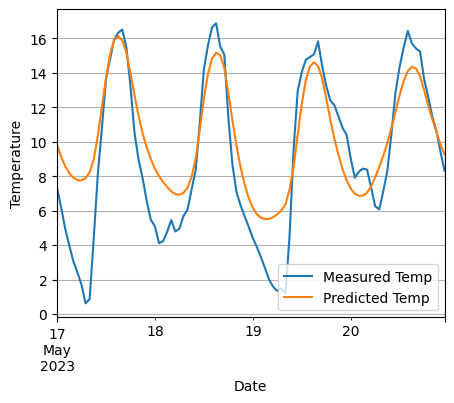

"\ntest_loss = model.evaluate(X_test, y_test)\nprint(f'Test Loss: {test_loss}')\n\n# Make predictions\ny_pred = model.predict(X_test)\ny_test = y_test.reshape(-1, 1)\ny_test_scale = np.concatenate((y_test,y_pred), axis=1)\ny_test_inv = scaler.inverse_transform(y_test_scale)\n\nprint(y_test_inv.shape)\ntemp = data[train_size+val_size+seq_length:]\ntemp['y_test_inv'] = y_test_inv[:,0]\ntemp['y_predict_inv'] = y_test_inv[:,1]\n\nprint(temp)\n"

In [23]:
# Evaluate the model on the test set
test_loss = model.evaluate(X, y)
print(f'Test Loss: {test_loss}')


# Make predictions
y_pred = model.predict(X)
y_test = y.reshape(-1, 1)
y_test_scale = np.concatenate((y_test,y_pred), axis=1)
y_test_inv = scaler.inverse_transform(y_test_scale)

print(y_test_inv.shape)
print(data.shape)
data_ = data.iloc[24:]
print(data_.shape)

data_['y_test_inv'] = y_test_inv[:,0]
data_['y_predict_inv'] = y_test_inv[:,1]

print(data_)

#start_date = data.index.min()
#end_date = data.index.max()

start_date = '2023-05-17'
end_date = '2023-05-20'

data_['y_test_inv'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='Measured Temp')
data_['y_predict_inv'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='Predicted Temp')
plt.legend()
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.grid(True)
plt.show()


'''
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
y_pred = model.predict(X_test)
y_test = y_test.reshape(-1, 1)
y_test_scale = np.concatenate((y_test,y_pred), axis=1)
y_test_inv = scaler.inverse_transform(y_test_scale)

print(y_test_inv.shape)
temp = data[train_size+val_size+seq_length:]
temp['y_test_inv'] = y_test_inv[:,0]
temp['y_predict_inv'] = y_test_inv[:,1]

print(temp)
'''

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Convert to time series format
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10
X_train, y_train = create_sequences(X_scaled, y_scaled, TIME_STEPS)


model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(TIME_STEPS, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')


early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/50
192/192 [==============================] - 21s 44ms/step - loss: 0.0472 - val_loss: 0.0234
Epoch 2/50
192/192 [==============================] - 6s 31ms/step - loss: 0.0160 - val_loss: 0.0190
Epoch 3/50
192/192 [==============================] - 6s 31ms/step - loss: 0.0149 - val_loss: 0.0187
Epoch 4/50
192/192 [==============================] - 6s 30ms/step - loss: 0.0138 - val_loss: 0.0151
Epoch 5/50
192/192 [==============================] - 6s 31ms/step - loss: 0.0127 - val_loss: 0.0136
Epoch 6/50
192/192 [==============================] - 6s 31ms/step - loss: 0.0114 - val_loss: 0.0100
Epoch 7/50
192/192 [==============================] - 6s 30ms/step - loss: 0.0103 - val_loss: 0.0087
Epoch 8/50
192/192 [==============================] - 6s 30ms/step - loss: 0.0095 - val_loss: 0.0074
Epoch 9/50
192/192 [==============================] - 6s 30ms/step - loss: 0.0090 - val_loss: 0.0112
Epoch 10/50
192/192 [==============================] - 6s 30ms/step - loss: 0.0085 - val_l

1005/1005 [==============================] - 12s 9ms/step
                     predicted_weather_metric
2020-06-01 10:00:00                 10.373462
2020-06-01 11:00:00                 10.613492
2020-06-01 12:00:00                 10.950226
2020-06-01 13:00:00                 11.327935
2020-06-01 14:00:00                 11.637508
...                                       ...
2024-01-31 19:00:00                 26.566092
2024-01-31 20:00:00                 24.182030
2024-01-31 21:00:00                 21.810266
2024-01-31 22:00:00                 19.752563
2024-01-31 23:00:00                 18.119129

[32143 rows x 1 columns]
                     Temp_sat
2023-03-16 05:00:00     19.87
2023-03-16 06:00:00     19.96
2023-03-16 07:00:00     22.19
2023-03-16 08:00:00     25.13
2023-03-16 09:00:00     27.16
...                       ...
2024-01-31 19:00:00     22.66
2024-01-31 20:00:00     21.40
2024-01-31 21:00:00     20.09
2024-01-31 22:00:00     18.89
2024-01-31 23:00:00     17.87

[76

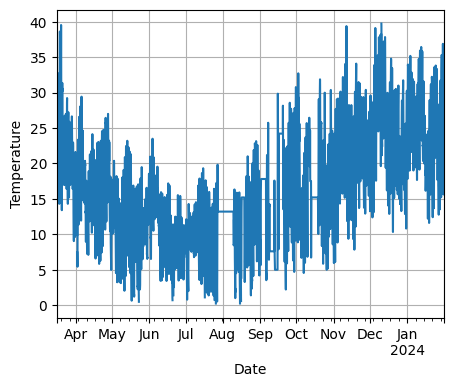

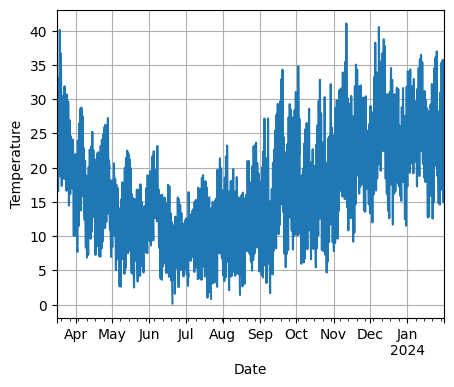

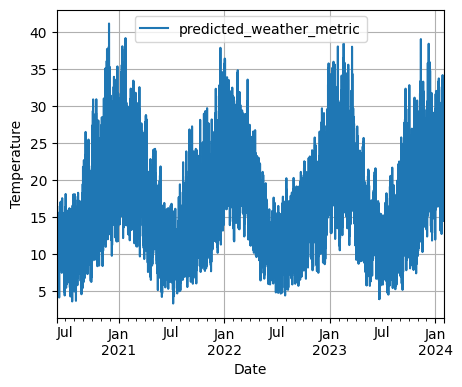

In [93]:
start_date = df_pow_32A.index.min()
end_date = df_pow_32A.index.max()


# Use the trained model to predict actual weather data for the period with only satellite data
future_satellite_data = df_met_sat[['Temp_sat']][start_date:end_date]
future_satellite_scaled = scaler_X.transform(satellite_data_only_period)


X_future_seq = []
for i in range(len(future_satellite_scaled) - TIME_STEPS):
    X_future_seq.append(future_satellite_scaled[i:i + TIME_STEPS])
X_future_seq = np.array(X_future_seq)

future_predictions = model.predict(X_future_seq)
future_predictions_inverse = scaler_y.inverse_transform(future_predictions)

future_dates = future_satellite_data.index[TIME_STEPS:]
predictions_df = pd.DataFrame(future_predictions_inverse, index=future_dates, columns=['predicted_weather_metric'])


print(predictions_df)
print(data[['Temp_sat']])
print(data[['Temp_mes']])

data['Temp_mes'].resample('H').mean().plot(figsize=(5, 4))
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.grid(True)
plt.show()

data['Temp_sat'].resample('H').mean().plot(figsize=(5, 4))
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.grid(True)
plt.show()


predictions_df.resample('H').mean().plot(figsize=(5, 4))
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.grid(True)
plt.show()


In [4]:
# Define the morning hour range
start_hour = 6
end_hour = 21

# Filter rows based on morning hour range
df = df[(df.index.hour >= start_hour) & (df.index.hour < end_hour)]
print(df.shape)

(1206000, 1)


In [5]:
#Filtering cutailment period
# Define window size (number of hours in the sliding window)
#window_size = 4

# Function to check if all values in the window are the same
#def is_constant(window):
#    return np.all(window == window[0])

# Identify curtailment periods using a rolling window
#df['curtailment'] = df['Power'].rolling(window=window_size, min_periods=1).apply(is_constant)

# Convert rolling result to boolean (1.0 for curtailment, 0.0 for non-curtailment)
#df['curtailment'] = df['curtailment'] == 1.0

# Filter out curtailment periods
#df = df[~df['curtailment']]
#print(df.shape)

In [6]:
#df = df[df['POA']>100]
#print(df.shape)

In [7]:
'''
# Rolling statistics
window_size = 5
df['rolling_mean_POA'] = df['POA'].rolling(window=window_size, center=True).mean()
df['rolling_std_POA'] = df['POA'].rolling(window=window_size, center=True).std()

df['rolling_mean_Power'] = df['Power'].rolling(window=window_size, center=True).mean()
df['rolling_std_Power'] = df['Power'].rolling(window=window_size, center=True).std()

# Filtering outliers using IQA
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for power output and irradiance
Q1_Power = df['Power'].quantile(0.25)
Q3_Power = df['Power'].quantile(0.75)
IQR_Power = Q3_Power - Q1_Power

Q1_POA = df['POA'].quantile(0.25)
Q3_POA = df['POA'].quantile(0.75)
IQR_POA = Q3_POA - Q1_POA

# Define lower and upper bounds for filtering
lower_bound_Power = Q1_Power - 1.5 * IQR_Power
upper_bound_Power = Q3_Power + 1.5 * IQR_Power

lower_bound_POA = Q1_POA - 1.5 * IQR_POA
upper_bound_POA = Q3_POA + 1.5 * IQR_POA

# Filter out data points outside the bounds
df = df[
    (df['Power'] >= lower_bound_Power) & (df['Power'] <= upper_bound_Power) &
    (df['POA'] >= lower_bound_POA) & (df['POA'] <= upper_bound_POA)
]

print(df.shape)
'''

# Identify outliers using roling mean
#deviation_threshold = 2  # 2 standard deviations
#df_filtered = df[
#    (df['Power'] >= df['rolling_mean_Power'] - deviation_threshold * df['rolling_std_Power']) &
#    (df['Power'] <= df['rolling_mean_Power'] + deviation_threshold * df['rolling_std_Power']) &
#    (df['POA'] >= df['rolling_mean_POA'] - deviation_threshold * df['rolling_std_POA']) &
#    (df['POA'] <= df['rolling_mean_POA'] + deviation_threshold * df['rolling_std_POA'])
#]
#
#print(df.shape)

"\n# Rolling statistics\nwindow_size = 5\ndf['rolling_mean_POA'] = df['POA'].rolling(window=window_size, center=True).mean()\ndf['rolling_std_POA'] = df['POA'].rolling(window=window_size, center=True).std()\n\ndf['rolling_mean_Power'] = df['Power'].rolling(window=window_size, center=True).mean()\ndf['rolling_std_Power'] = df['Power'].rolling(window=window_size, center=True).std()\n\n# Filtering outliers using IQA\n# Calculate Q1 (25th percentile) and Q3 (75th percentile) for power output and irradiance\nQ1_Power = df['Power'].quantile(0.25)\nQ3_Power = df['Power'].quantile(0.75)\nIQR_Power = Q3_Power - Q1_Power\n\nQ1_POA = df['POA'].quantile(0.25)\nQ3_POA = df['POA'].quantile(0.75)\nIQR_POA = Q3_POA - Q1_POA\n\n# Define lower and upper bounds for filtering\nlower_bound_Power = Q1_Power - 1.5 * IQR_Power\nupper_bound_Power = Q3_Power + 1.5 * IQR_Power\n\nlower_bound_POA = Q1_POA - 1.5 * IQR_POA\nupper_bound_POA = Q3_POA + 1.5 * IQR_POA\n\n# Filter out data points outside the bounds\ndf 

In [8]:
#from sklearn.impute import KNNImputer
# Create a KNN imputer object
#original_index = df.index

# Select columns to impute
#columns_to_impute = ['Power','POA', 'Tmod']

# Create a KNN imputer object
#knn_imputer = KNNImputer(n_neighbors=5)

# Fit and transform only the selected columns
#df_imputed_values = knn_imputer.fit_transform(df[columns_to_impute])

# Convert the result back to a DataFrame and restore the original index
#df = pd.DataFrame(df_imputed_values, columns=columns_to_impute, index=original_index)


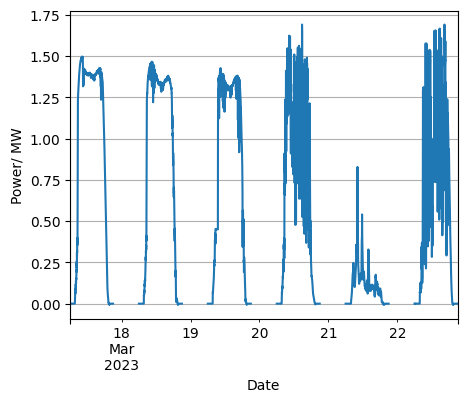

In [9]:
# Define the period you want to plot
start_date = '2023-03-17'
end_date = '2023-03-22'

# Slice the DataFrame based on the specified period
df_period = df[start_date:end_date]

df_period['Power'].resample('1min').mean().plot(figsize=(5, 4))
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.grid(True)
plt.show()


In [10]:
df.shape

(1206000, 1)

In [11]:
df.describe()

,Power
count,1.206000e+06
mean,5.388920e-01
std,6.173490e-01
min,-3.241317e-02
25%,0.000000e+00
50%,2.245757e-01
75%,1.120755e+00
max,1.701438e+00


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Example: Generate synthetic time series data (replace with your own data loading)
np.random.seed(42)

# Define the period you want to plot
start_date = df.index.min()
end_date = df.index.max()

temp = df[start_date:end_date][['Power']].resample('5min').mean()
print(temp.isnull().any().any())
print(np.any(np.isinf(temp)))
print(temp.shape)
temp_cleaned = temp.dropna()
print(temp_cleaned.shape)
data = temp_cleaned.values
print(temp_cleaned.index)

True
False
(385812, 1)
(241200, 1)
DatetimeIndex(['2020-06-01 06:00:00', '2020-06-01 06:05:00',
               '2020-06-01 06:10:00', '2020-06-01 06:15:00',
               '2020-06-01 06:20:00', '2020-06-01 06:25:00',
               '2020-06-01 06:30:00', '2020-06-01 06:35:00',
               '2020-06-01 06:40:00', '2020-06-01 06:45:00',
               ...
               '2024-01-31 20:10:00', '2024-01-31 20:15:00',
               '2024-01-31 20:20:00', '2024-01-31 20:25:00',
               '2024-01-31 20:30:00', '2024-01-31 20:35:00',
               '2024-01-31 20:40:00', '2024-01-31 20:45:00',
               '2024-01-31 20:50:00', '2024-01-31 20:55:00'],
              dtype='datetime64[ns]', name='time', length=241200, freq=None)


In [13]:
# Normalize data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

In [14]:
# Create sequences/windows
'''
timesteps = 5 # Length of each sequence/window
num_sequences = len(data_normalized) - timesteps + 1

# Initialize an array to hold the sequences
sequences = np.zeros((num_sequences, timesteps, 1))

for i in range(num_sequences):
    sequences[i] = data_normalized[i:i + timesteps].reshape(-1, 1)

# Print the shape of the resulting three-dimensional array
print("Shape of the sequences array:", sequences.shape)
'''


# Create sequences for LSTM
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        seq = data[i:i + timesteps]
        sequences.append(seq)
    return np.array(sequences)


# Train-test split
#X_train, X_test = train_test_split(sequences, test_size=0.2, random_state=42)


# Define the split ratio
train_ratio = 0.8
test_ratio = 0.2
num_train_samples = int(train_ratio * len(data_normalized))

# Split the data
train_data = data_normalized[:num_train_samples]
test_data = data_normalized[num_train_samples:]

train_data_date = temp_cleaned.index[:num_train_samples]
test_data_date = temp_cleaned.index[num_train_samples:]


timesteps = 30  # Example sequence length
train_sequences = create_sequences(train_data, timesteps)
test_sequences = create_sequences(test_data, timesteps)

print("Shape of the train sequences array:", train_sequences.shape)
print("Shape of the test sequences array:", test_sequences.shape)


Shape of the train sequences array: (192930, 30, 1)
Shape of the test sequences array: (48210, 30, 1)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30, 1)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 128)                  66560     ['input_2[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 128)                  16512     ['lstm_2[0][0]']              
                                                                                                  
 dense_6 (Dense)             (None, 16)                   2064      ['dense_5[0][0]']             
                                                                                            

KeyError: 'val_loss'

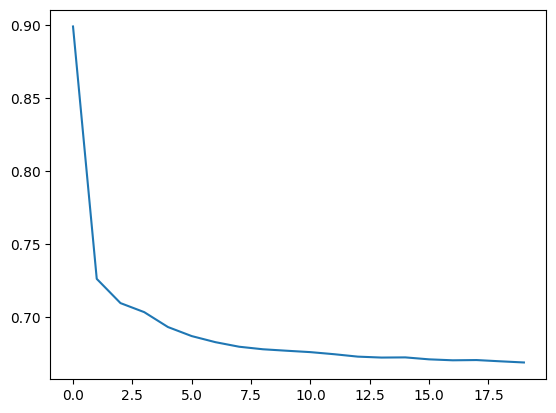

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# Function to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Hyperparameters
input_dim = 1   
latent_dim = 16
intermediate_dim = 128
dropout_rate = 0.1

# Encoder
inputs = Input(shape=(timesteps, input_dim))
h = LSTM(intermediate_dim, return_sequences=False,dropout=dropout_rate, recurrent_dropout=dropout_rate)(inputs)
h = Dense(intermediate_dim, activation='relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_repeat = RepeatVector(timesteps)
decoder_lstm = LSTM(intermediate_dim, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
decoder_output = TimeDistributed(Dense(input_dim))


h_decoded = decoder_repeat(z)
x_decoded_mean = decoder_lstm(h_decoded)
x_decoded_mean = decoder_output(x_decoded_mean)


# VAE model
vae = Model(inputs, x_decoded_mean)

# Loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(x_decoded_mean))
reconstruction_loss *= timesteps * input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 0.15*kl_loss)
vae.add_loss(vae_loss)

# Compile model
#vae.compile(optimizer='rmsprop')
optimizer = Adam(learning_rate=1e-3)
vae.compile(optimizer=optimizer)
vae.summary()


# Train the VAE with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = vae.fit(train_sequences, epochs=20, batch_size=64, validation_split=0.0, callbacks=[early_stopping])

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Encode and decode some data points
encoder = Model(inputs, z_mean)
encoded_data = encoder.predict(train_sequences)

# Display some of the encoded data
plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Encoded Data")
plt.show()


# Extract latent representations and reconstructed sequences
#reconstructed_sequences = vae.predict(X_train)

In [22]:
vae.save('/home/ahilan/gen-research/neoen-site/models/df_pow_32A_3year_power_sample_5min.h5')

6030/6030 [==============================] - 66s 11ms/step


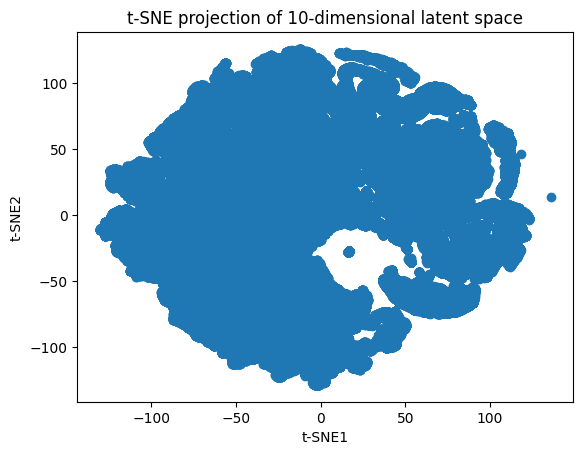

In [23]:
# Encode and decode some data points
encoder = Model(inputs, z_mean)
encoded_data = encoder.predict(train_sequences)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(encoded_data)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE projection of 10-dimensional latent space')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

In [24]:
data = test_data
data_sequences = test_sequences
date_index = test_data_date

reconstructed_sequences = vae.predict(data_sequences)

# 1. Reshape sequences back to original form
original_shape = (len(data), 1)
reconstructed_original_data = np.zeros(original_shape)
reconstructed_vae_data = np.zeros(original_shape)

for i in range(len(data_sequences) - timesteps):
    reconstructed_original_data[i:i + timesteps] = data_sequences[i]
    reconstructed_vae_data[i:i + timesteps] = reconstructed_sequences[i]


X_test_original = scaler.inverse_transform(reconstructed_original_data)
X_test_vae = scaler.inverse_transform(reconstructed_vae_data)

df_orginal = pd.DataFrame(data = X_test_original, index = date_index, columns = ['Power'])
df_vae_output = pd.DataFrame(data = X_test_vae, index = date_index, columns = ['Power'])


1507/1507 [==============================] - 37s 23ms/step


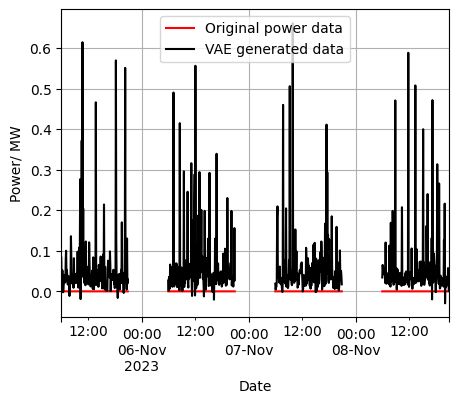

"\ndf_period['POA'].resample('H').mean().plot(figsize=(5, 4))\nplt.ylabel('POA/ WM$^{-2}$')\nplt.xlabel('Date')\nplt.grid(True)\nplt.show()\n\ndf_period['Power'].resample('H').mean().plot(figsize=(5, 4))\nplt.ylabel('Power/ MW')\nplt.xlabel('Date')\nplt.grid(True)\nplt.show()\n"

In [37]:
# Define the period you want to plot
start_date = '2023-11-05'
end_date = '2023-11-08'

# Slice the DataFrame based on the specified period
df_orginal_period = df_orginal[start_date:end_date]
df_vae_output_period = df_vae_output[start_date:end_date]


df_orginal_period['Power'].resample('5min').mean().plot(figsize=(5, 4), color =['Red'],label='Original power data')
df_vae_output_period['Power'].resample('5min').mean().plot(figsize=(5, 4),color =['Black'],label='VAE generated data')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()



'''
df_period['POA'].resample('H').mean().plot(figsize=(5, 4))
plt.ylabel('POA/ WM$^{-2}$')
plt.xlabel('Date')
plt.grid(True)
plt.show()

df_period['Power'].resample('H').mean().plot(figsize=(5, 4))
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.grid(True)
plt.show()
'''

In [45]:
forecast_horizon = 30

# LSTM for long-term forecasting using encoded latent representations
lstm_inputs = Input(shape=(latent_dim,))
lstm_h = RepeatVector(forecast_horizon)(lstm_inputs)  # Forecasting into future time steps
lstm_outputs = LSTM(50, activation='relu', return_sequences=True)(lstm_h)
forecast_outputs = Dense(original_dim)(lstm_outputs)

lstm_forecast_model = Model(lstm_inputs, forecast_outputs)
lstm_forecast_model.compile(optimizer='adam', loss='mse')

# Reshape encoded data for LSTM training
X_train_encoded = np.reshape(encoded_data, (encoded_data.shape[0], -1, encoded_data.shape[1]))

# Prepare target data for LSTM (shifted sequences for forecasting)
def create_target_sequences(data, seq_length, forecast_horizon):
    target_sequences = []
    for i in range(seq_length, len(data) - forecast_horizon):
        target_sequences.append(data[i:i+forecast_horizon])
    return np.array(target_sequences)

Y_train = create_target_sequences(time_series_data, sequence_length, forecast_horizon)

# Train the LSTM model
lstm_forecast_model.fit(X_train_encoded[:, :-forecast_horizon, :], Y_train, epochs=50, batch_size=32)

# Generate forecasts
encoded_input = encoder.predict(X_test)  # Use encoder to get latent representation of test data
forecast_input = np.repeat(encoded_input[:, np.newaxis, :], forecast_horizon, axis=1)  # Repeat for forecasting horizon
forecasts = lstm_forecast_model.predict(forecast_input)

# forecasts contain the predicted time series data for the forecast horizon
# forecasts contain the predicted time series data for the forecast horizon


6030/6030 [==============================] - 79s 13ms/step
Epoch 1/50


ValueError: in user code:

    File "/home/ahilan/kernels/default/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/ahilan/kernels/default/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ahilan/kernels/default/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/ahilan/kernels/default/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/home/ahilan/kernels/default/.venv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/ahilan/kernels/default/.venv/lib/python3.8/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_10" is incompatible with the layer: expected shape=(None, 16), found shape=(None, 0, 16)


In [77]:
data = test_data
data_sequences = test_sequences
date_index = test_data_date

# Calculate reconstruction loss
reconstructed_sequences = vae.predict(data_sequences)
reconstruction_errors = np.mean(np.square(data_sequences - reconstructed_sequences), axis=(1, 2))

# Threshold for anomaly detection
threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
print(threshold)

anomalies = reconstruction_errors > threshold

# Mark anomalies in the original data
df_vae_output['Anomaly'] = 0
df_vae_output['Anomaly'][timesteps:] = anomalies


502/502 [==============================] - 18s 35ms/step
0.03737286214003002


/tmp/ipykernel_2289625/521013637.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vae_output['Anomaly'][timesteps:] = anomalies


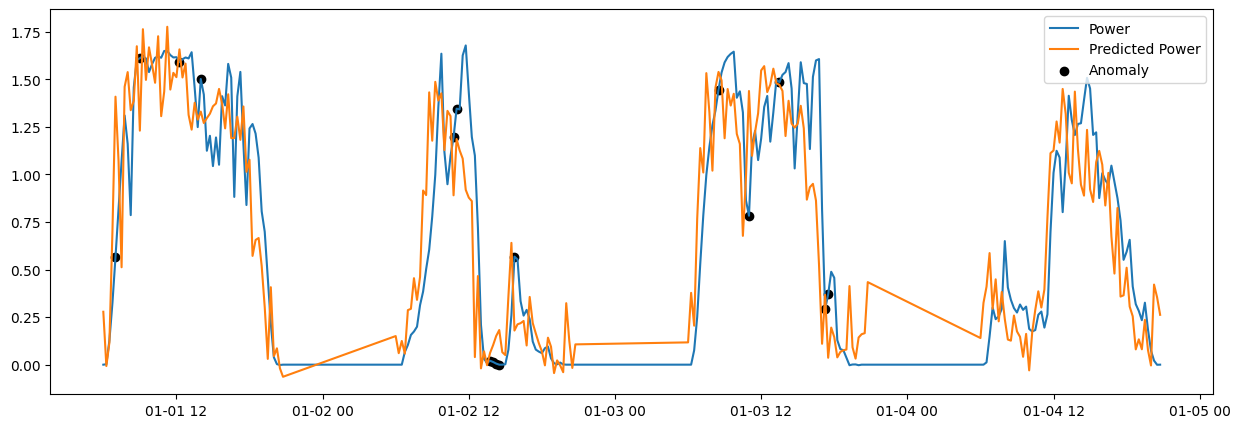

In [78]:
# Define the period you want to plot
start_date = '2024-01-01'
end_date = '2024-01-04'

# Slice the DataFrame based on the specified period
df_orginal_period = df_orginal[start_date:end_date]
df_vae_output_period = df_vae_output[start_date:end_date]

plt.figure(figsize=(15, 5))
plt.plot(df_orginal_period.index, df_orginal_period['Power'], label='Power')
plt.plot(df_vae_output_period.index, df_vae_output_period['Power'], label='Predicted Power')
plt.scatter(df_vae_output_period.index[df_vae_output_period['Anomaly'] == 1], df_orginal_period['Power'][df_vae_output['Anomaly'] == 1], color='black', label='Anomaly')
plt.legend()
plt.show()

In [105]:
reconstructed_sequences = vae.predict(X_train)
reconstruction_errors = np.mean(np.square(X_train - reconstructed_sequences), axis=(1, 2))

# Threshold for anomaly detection
threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)

anomalies = reconstruction_errors > threshold

df['Anomaly'] = 0
df['Anomaly'][time_steps:] = anomalies


# Visualize anomalies
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

2216/2216 [==============================] - 72s 33ms/step


NameError: name 'X_test' is not defined

73/73 [==============================] - 1s 5ms/step


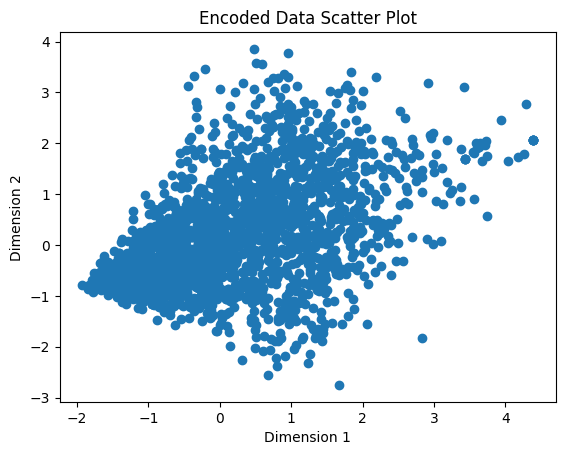

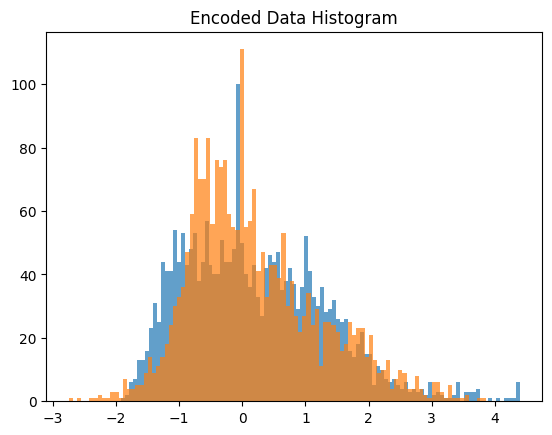

73/73 [==============================] - 2s 8ms/step


In [277]:
# Encode and decode some data points
encoder = Model(inputs, z_mean)
encoded_data = encoder.predict(X_train)

# Display some of the encoded data
plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Encoded Data Scatter Plot")
plt.show()

plt.hist(encoded_data[:, 0], bins=100, alpha=0.7, label='Feature 1')
plt.hist(encoded_data[:, 1], bins=100, alpha=0.7, label='Feature 2')
plt.title("Encoded Data Histogram")
plt.show()

# Extract latent representations and reconstructed sequences
reconstructed_sequences = vae.predict(X_train)

(2318, 1)
(2318, 1)


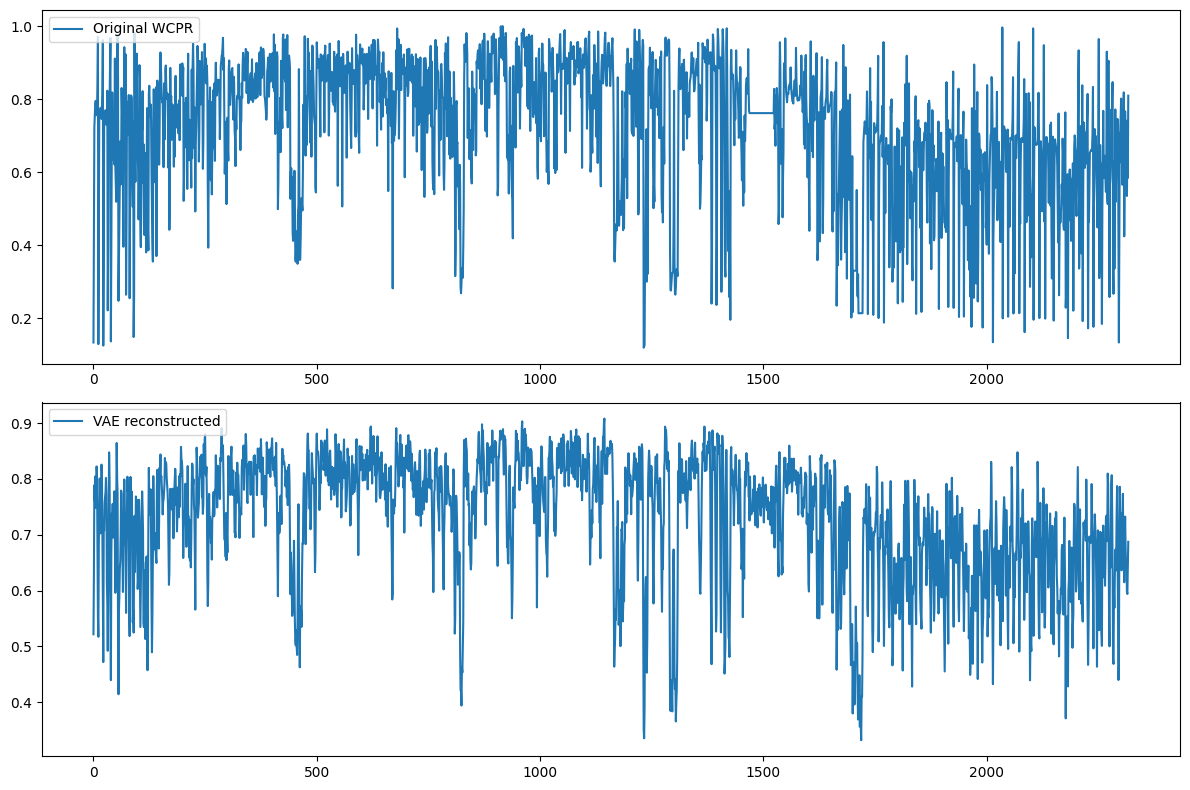

In [278]:
# Plot original vs. reconstructed time series
#(reconstructed_sequences * data_std) + data_mean

# 1. Reshape sequences back to original form
original_shape = (len(data_normalized), 1)
reconstructed_original_data = np.zeros(original_shape)
reconstructed_vae_data = np.zeros(original_shape)

for i in range(num_sequences):
    reconstructed_original_data[i:i + timesteps] = sequences[i]
    reconstructed_vae_data[i:i + timesteps] = reconstructed_sequences[i]


reconstructed_original_data_no_norm = (reconstructed_original_data * data_std) + data_mean
reconstructed_vae_data_no_norm = (reconstructed_vae_data * data_std) + data_mean

print(reconstructed_original_data_no_norm.shape)
print(reconstructed_vae_data_no_norm.shape)

temp_cleaned['original'] = reconstructed_original_data_no_norm
temp_cleaned['vae_constructed'] = reconstructed_vae_data_no_norm


# Plotting the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(temp_cleaned['original'], label='Original WCPR')
plt.legend(loc='upper left')

plt.subplot(212)
plt.plot(temp_cleaned['vae_constructed'], label='VAE reconstructed')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()